<a href="https://colab.research.google.com/github/Nhathuyy/Fake-News-Covid/blob/main/FakeNew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dự báo tin tức giả mạo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# B1 Cài đặt thư viện

In [ ]:
import tensorflow as tf
tf.__version__
!sudo pip3 install keras

from tensorflow.python.keras.engine.sequential import Sequential

from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import re 
import nltk
import sklearn
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn

In [ ]:
#Download the corpus of stopwords from NLTK (Natural Language Toolkit)
nltk.download("stopwords") 
#Instantiate ProterStemmer()
ps = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# B2 Đọc file dữ liệu

In [ ]:
dataset = pd.read_csv("/content/fake-news-dataset.csv")

In [ ]:
dataset

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real
...,...,...,...
6415,6416,A tiger tested positive for COVID-19 please st...,fake
6416,6417,???Autopsies prove that COVID-19 is??� a blood...,fake
6417,6418,_A post claims a COVID-19 vaccine has already ...,fake
6418,6419,Aamir Khan Donate 250 Cr. In PM Relief Cares Fund,fake


# B3 Xử lý dữ liệu

In [ ]:
dataset.shape

(6420, 3)

Kiểm tra các giá trị bị thiếu (NaN)

In [ ]:
dataset = dataset.dropna(how='any',axis=0)

In [ ]:

dataset.isnull().sum()

id       0
tweet    0
label    0
dtype: int64

Tiền xử lý dữ liệu

Sử dụng Biểu thức chính quy, xóa tất cả dữ liệu phi văn bản bao gồm các biểu tượng, ký tự đặc biệt, biểu tượng cảm xúc và số. Chuẩn hóa trường hợp bằng cách chuyển đổi tất cả thành chữ thường. Chia các câu thành các từ, giảm các từ xuống gốc của chúng và loại bỏ bất kỳ từ dừng nào. Nối các từ đã tách với một khoảng trắng để tạo thành một câu đơn giản, sạch sẽ.

In [ ]:
def preprocess_column(col_name, col_length):
  preprocessed_data = []
  for i in range(0,col_length):
        col_value = dataset[col_name][i]
        col_value = re.sub('[^a-zA-Z]', ' ', col_value)
        col_value = col_value.lower()
        col_value = col_value.split()
        col_value = [ps.stem(word) for word in col_value if not word in set(stopwords.words('english'))]
        col_value = ' '.join(col_value)
        preprocessed_data.append(col_value)
  return preprocessed_data

In [ ]:
#Gọi hàm cho cột "tweet"
preprocessed_train = preprocess_column("tweet",6420)

 Xử lý các giá trị phân loại- Mã hóa nhãn

Thay thế các danh mục trong cột phụ thuộc (y) bằng các giá trị số để xử lý dễ dàng hơn ở dạng máy có thể đọc được. Ở đây, chúng ta có "Thật" và "Giả" sẽ được gán giá trị tương ứng là "1" và "0" (theo thứ tự bảng chữ cái)

In [ ]:
le=LabelEncoder()
dataset['label']=le.fit_transform(dataset['label'])

# Bộ đếm số

# B4 Cách hoạt động của bộ đếm số

Chuyển đổi một tập hợp các tài liệu văn bản thành một biểu diễn ma trận thưa thớt của số lượng mã thông báo. Hoặc, khá đơn giản, nó được sử dụng để chuyển một văn bản nhất định thành một vectơ trên cơ sở tần suất (số lượng) của mỗi từ xuất hiện trong toàn bộ văn bản

In [ ]:

cv = CountVectorizer(max_features = 2000)
x = cv.fit_transform(preprocessed_train).toarray() #preprocessed tweets in the form of a sparse matrix

In [ ]:
#Define the dependent variable (prediction column)
y = dataset.iloc[:,2:3].values

# B5 Split the dataset into Train and Test sets
chia tỷ lệ 20:80 

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2, random_state = 0)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(5136, 2000)
(5136, 1)
(1284, 2000)
(1284, 1)


# Hồi quy logistic

Nó là một thuật toán phân loại trong học máy sử dụng một hoặc nhiều biến độc lập để xác định kết quả. Kết quả được đo bằng một biến phân đôi có nghĩa là nó sẽ chỉ có hai kết quả có thể xảy ra. Ví dụ, nó có thể được sử dụng để xác định xem một email có phải là thư rác hay không, bằng cách sử dụng tỷ lệ từ sai chính tả, một dấu hiệu phổ biến của thư rác.


In [ ]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(x_train,y_train)
lr_ypred=lr.predict(x_test)
lr_acc = sklearn.metrics.accuracy_score(lr_ypred,y_test)
print("Logistic Regression Accuracy: ")
print(lr_acc*100,"%")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy: 
92.7570093457944 %


In [ ]:
# pr= lr.predict(cv.transform([text_cleaner(headline2)]))
# if pr>0.5:
#   print("Real")
# else:
#   print("Fake!")

# Naive Bayes Classifier

Thuật toán Naive Bayes dựa trên định lý Bayes với giả định về sự độc lập giữa mọi cặp đặc trưng. Nó giả định rằng sự hiện diện của một đối tượng cụ thể trong một lớp không liên quan đến sự hiện diện của bất kỳ đối tượng địa lý nào khác. Ngay cả khi các tính năng phụ thuộc vào nhau, tất cả các đặc tính này đều đóng góp vào xác suất một cách độc lập.


In [ ]:
from sklearn.naive_bayes import GaussianNB
nb=GaussianNB()
nb.fit(x_train,y_train)
nb_ypred=nb.predict(x_test)
nb_acc = sklearn.metrics.accuracy_score(nb_ypred,y_test)
print("Naive Bayes Accuracy: ")
print(nb_acc*100,"%")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Naive Bayes Accuracy: 
87.14953271028037 %


# Stochastic Gradient Descent
lặp đi lặp lại để tối ưu hóa một hàm mục tiêu với các đặc tính độ mịn phù hợp. Nó có thể được coi là xấp xỉ ngẫu nhiên của tối ưu hóa giảm dần gradient, vì nó thay thế gradient thực tế bằng một ước tính của nó.

In [ ]:
from sklearn.linear_model import SGDClassifier
sgd=SGDClassifier(loss='modified_huber',shuffle=True, random_state=15)
sgd.fit(x_train,y_train)
sgd_ypred=sgd.predict(x_test)
sgd_acc = sklearn.metrics.accuracy_score(sgd_ypred,y_test)
print("Stochastic Gradient Descent Accuracy: ")
print(sgd_acc*100,"%")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Stochastic Gradient Descent Accuracy: 
91.04361370716511 %


# K-Nearest Neighbour
Phân loại dựa trên Nearest-Neighbor là một kiểu lười học vì nó không cố gắng xây dựng một mô hình nội bộ chung mà chỉ lưu trữ các phiên bản của dữ liệu đào tạo. Phân loại được tính toán từ đa số phiếu đơn giản của 'k' các láng giềng gần nhất của mỗi điểm.


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train,y_train)
knn_ypred=knn.predict(x_test)
knn_acc = sklearn.metrics.accuracy_score(knn_ypred,y_test)
print("K-Nearest Neighbour Accuracy: ")
print(knn_acc*100,"%")

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


K-Nearest Neighbour Accuracy: 
77.80373831775701 %


# Decision Tree
Cây Quyết định xây dựng các mô hình dưới dạng cấu trúc cây. Nó phân loại dữ liệu thành các loại tốt hơn và mịn hơn: từ thân cây đến cành cho đến lá. Nó sử dụng quy tắc nếu-thì của toán học để tạo các danh mục con phù hợp với các danh mục rộng hơn và cho phép phân loại chính xác, hữu cơ.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
#Note: tweak values for max acc
dtree=DecisionTreeClassifier(max_depth=40,random_state=18,max_features=None, min_samples_leaf=8)
dtree.fit(x_train,y_train)
dtree_ypred=dtree.predict(x_test)
dtree_acc = sklearn.metrics.accuracy_score(dtree_ypred,y_test)
print("Decision Tree Accuracy: ")
print(dtree_acc*100,"%")

Decision Tree Accuracy: 
87.53894080996885 %


# Random Forest
Cây quyết định ngẫu nhiên hoặc rừng ngẫu nhiên là một phương pháp học tập tổng hợp để phân loại, hồi quy, v.v. có nghĩa là một mô hình rừng ngẫu nhiên được tạo thành từ một số lượng lớn các cây quyết định nhỏ, được gọi là bộ ước lượng, mỗi cây đưa ra dự đoán của riêng chúng. Mô hình rừng ngẫu nhiên kết hợp các dự đoán của người ước lượng để đưa ra dự đoán chính xác hơn.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfm=RandomForestClassifier(n_estimators=75,oob_score=True,n_jobs=-1, random_state=20,max_features=None,min_samples_leaf=2)
rfm.fit(x_train,y_train)
rfm_ypred=rfm.predict(x_test)
rfm_acc = sklearn.metrics.accuracy_score(rfm_ypred,y_test)
print("Random Forest Accuracy: ")
print(rfm_acc*100,"%")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Random Forest Accuracy: 
90.57632398753894 %


# Support Vector Machine
Máy vectơ hỗ trợ là một bộ phân loại biểu thị dữ liệu đào tạo dưới dạng các điểm trong không gian được phân tách thành các loại bằng một khoảng cách càng rộng càng tốt. Các điểm mới sau đó được thêm vào không gian bằng cách dự đoán chúng thuộc loại nào và chúng sẽ thuộc không gian nào.

In [ ]:
from sklearn.svm import SVC 
svm=SVC(kernel="linear",C=0.025,random_state=None)
svm.fit(x_train,y_train)
svm_ypred=svm.predict(x_test)
svm_acc = sklearn.metrics.accuracy_score(svm_ypred,y_test)
print("Support Vector Machine Accuracy: ")
print(svm_acc*100,"%")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Support Vector Machine Accuracy: 
92.13395638629284 %


# Classification ANN
Phân loại ANN tìm cách phân loại một quan sát thuộc một lớp rời rạc nào đó như một chức năng của các đầu vào. Các đặc trưng đầu vào (các biến độc lập) có thể là loại phân loại hoặc số, tuy nhiên, chúng tôi yêu cầu một đặc điểm phân loại là biến phụ thuộc.

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(x_train)
X_text = sc.transform(x_test)
ann = tf.keras.models.Sequential()




In [ ]:
ann.add(tf.keras.layers.Dense(units=4, activation='relu'))

In [ ]:
ann.add(tf.keras.layers.Dense(units=4, activation='relu'))

In [ ]:
ann.add(tf.keras.layers.Dense(units=4, activation='sigmoid'))

In [ ]:
ann.compile(optimizer = 'adam', loss='binary_crossentropy', metrics= ['accuracy'])

In [ ]:
ann.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
ann.fit(x_train, y_train, batch_size = 50, epochs =100)


Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


103/103 [==============================] - 1s 3ms/step - loss: 1.0021 - accuracy: 0.5430
Epoch 2/100
103/103 [==============================] - 0s 3ms/step - loss: 0.5612 - accuracy: 0.8092
Epoch 3/100
103/103 [==============================] - 0s 3ms/step - loss: 0.2972 - accuracy: 0.9258
Epoch 4/100
103/103 [==============================] - 0s 3ms/step - loss: 0.1871 - accuracy: 0.9484
Epoch 5/100
103/103 [==============================] - 0s 3ms/step - loss: 0.1332 - accuracy: 0.9636
Epoch 6/100
103/103 [==============================] - 0s 3ms/step - loss: 0.1019 - accuracy: 0.9714
Epoch 7/100
103/103 [==============================] - 0s 3ms/step - loss: 0.0813 - accuracy: 0.9776
Epoch 8/100
103/103 [==============================] - 0s 3ms/step - loss: 0.0664 - accuracy: 0.9811
Epoch 9/100
103/103 [==============================] - 0s 3ms/step - loss: 0.0549 - accuracy: 0.9842
Epoch 10/100
103/103 [==============================] - 0s 2ms/step - loss: 0.0461 - accuracy: 0.9868
E

In [ ]:
y_test

array([[0],
       [1],
       [0],
       ...,
       [1],
       [0],
       [1]])

In [ ]:
y_pred = ann.predict(x_test)
y_pred = (y_pred > 0.5)
y_pred = y_pred.astype(int)


In [ ]:
y_pred

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0]])

In [ ]:

from sklearn.metrics import confusion_matrix, accuracy_score


In [ ]:
dm = confusion_matrix(y_test, np.argmax(y_pred, axis=1))


In [ ]:
print(dm)

[[574  53]
 [ 75 582]]


kết quả
True positive: 574 (thật)

True negative: 582 (giả) 

False-positive: 53 (là tin giả nhưng dự đoán là tin thật)

False-negative: 75 (là tin thật nhưng dự đoán là tin giả)

In [ ]:
ann_acc = accuracy_score(y_test, y_pred)
print("Classification ANN Accuracy: ")
print(ann_acc*100,"%")


Classification ANN Accuracy: 
48.831775700934585 %


In [ ]:
model = Sequential()
model.add(Dense(units = 2000, kernel_initializer = "random_uniform", activation = "relu"))
model.add(Dense(units = 4000, kernel_initializer = "random_uniform", activation = "relu"))
model.add(Dense(units = 4000, kernel_initializer = "random_uniform", activation = "relu"))
model.add(Dense(units = 4000, kernel_initializer = "random_uniform", activation = "relu"))
model.add(Dense(units = 4000, kernel_initializer = "random_uniform", activation = "relu"))
model.add(Dense(units = 4000, kernel_initializer = "random_uniform", activation = "relu"))
model.add(Dense(units = 4000, kernel_initializer = "random_uniform", activation = "relu"))
model.add(Dense(units = 1, kernel_initializer = "random_uniform", activation = "sigmoid"))


In [ ]:
model.compile(optimizer = "rmsprop", loss="binary_crossentropy", metrics= ["accuracy"])
seq_history= model.fit(x_train,y_train, epochs = 5,verbose=1, steps_per_epoch=50)


Epoch 1/5
50/50 [==============================] - 8s 61ms/step - loss: 278.5877 - accuracy: 0.7755
Epoch 2/5
50/50 [==============================] - 3s 57ms/step - loss: 0.1389 - accuracy: 0.9574
Epoch 3/5
50/50 [==============================] - 3s 55ms/step - loss: 0.1516 - accuracy: 0.9511
Epoch 4/5
50/50 [==============================] - 3s 56ms/step - loss: 0.1018 - accuracy: 0.9772
Epoch 5/5
50/50 [==============================] - 3s 56ms/step - loss: 0.0216 - accuracy: 0.9940


In [ ]:
acc= model.evaluate(x_train, y_train)

161/161 [==============================] - 1s 5ms/step - loss: 0.0406 - accuracy: 0.9940


In [ ]:
print("Sequential Model Accuracy: ")
acc=acc[1]
print(acc*100,"%")

Sequential Model Accuracy: 
99.39641952514648 %


In [ ]:
headline1 = "Social gatherings of more than six people will be banned across England Wales and Scotland from tomorrow. But what are the new rules what happens if you break them and how do they differ across the nations? ðŸ‘‡"
headline2 = "Korona virus, very new deadly form of virus, china is suffering, may come to India immediately, avoid any form of cold drinks, ice creams, koolfee, etc, any type of preserved foods, milkshake, rough ice, ice colas, milk sweets older then 48 hours, for atleast 90 days from today."
headline3 = "As tuberculosis shaped modernism, so COVID-19 and our collective experience of staying inside for months on end will influence architectureâ€™s near future, @chaykak writes. https://t.co/ag34yZckbU"
headline4 = "SUBHAN ALLAH: AFTER CORONA VIRUS CHINA GOVT LIFTED BAN ON HOLY QURAN & ALLOWED CHINESE MUSLIMS TO READ THEIR SACRED BOOK! SO WHICH OF THE FAVORS OF YOUR LORD WOULD YOU DENY?"
headline5 = "#IndiaFightsCorona Following the national trend 17 States/UTs have more new recoveries than new cases. https://t.co/aHWwlaimmb"

In [ ]:
#function to clean the input text
def text_cleaner(text):
  text = re.sub('[^a-zA-Z]', ' ', text) 
  text = text.lower()
  text = text.split() 
  text = [ps.stem(word) for word in text if not word in set(stopwords.words('english'))]
  text = ' '.join(text)
  return text

In [ ]:
#function to predict
def predictor(text):
  if (ann.predict(cv.transform([text])))>0.5:
    print("Real")
  else:
    print("Fake!")

In [ ]:
accuracies= {
             "SEQ":acc,
             "ANN": ann_acc,
             "logreg": lr_acc, 
             "naive": nb_acc, 
             "SGD": sgd_acc, 
             "kNN": knn_acc, 
             "DT": dtree_acc, 
             "RF": rfm_acc, 
             "SVM": svm_acc
             }

print("Classification models in descending order of accuracy:")
sorted(accuracies.items(), key=lambda x: x[1],reverse=True)

Classification models in descending order of accuracy:


[('SEQ', 0.9939641952514648),
 ('logreg', 0.927570093457944),
 ('SVM', 0.9213395638629284),
 ('SGD', 0.910436137071651),
 ('RF', 0.9057632398753894),
 ('DT', 0.8753894080996885),
 ('naive', 0.8714953271028038),
 ('kNN', 0.7780373831775701),
 ('ANN', 0.4883177570093458)]

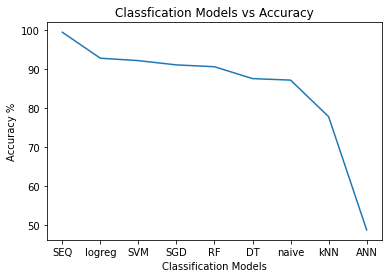

In [ ]:
lists = sorted(accuracies.items(), key=lambda x: x[1]*100,reverse=True) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

z = []
for i in y:
   z.append(i*100)
tuple(z)
plt.plot(x, z)

plt.title('Classfication Models vs Accuracy')
plt.xlabel('Classification Models')
plt.ylabel('Accuracy %')
plt.show()

Vì mô hình này có độ chính xác cao nhất, chúng tôi sẽ sử dụng mô hình này để dự đoán trong quá trình triển khai ứng dụng của mình

In [ ]:
model.save("fake-news.h5")

In [ ]:
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

def build_classifier():
  model = Sequential()
  model.add(Dense(units = 2000, kernel_initializer = "random_uniform", activation = "relu"))
  model.add(Dense(units = 4000, kernel_initializer = "random_uniform", activation = "relu"))
  model.add(Dense(units = 4000, kernel_initializer = "random_uniform", activation = "relu"))
  model.add(Dense(units = 4000, kernel_initializer = "random_uniform", activation = "relu"))
  model.add(Dense(units = 4000, kernel_initializer = "random_uniform", activation = "relu"))
  model.add(Dense(units = 4000, kernel_initializer = "random_uniform", activation = "relu"))
  model.add(Dense(units = 4000, kernel_initializer = "random_uniform", activation = "relu"))
  model.add(Dense(units = 1, kernel_initializer = "random_uniform", activation = "sigmoid"))
  model.compile(optimizer = "rmsprop", loss="binary_crossentropy", metrics= ["accuracy"])
  return model

In [ ]:
kf = KFold(n_splits=8, random_state=15, shuffle=True)
val_accuracy_per_fold = []
val_loss_per_fold = []

for train, test in kf.split(x, y):
  sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

model=build_classifier()
history = model.fit(x_train,y_train, epochs = 20,verbose=1, steps_per_epoch=50, validation_data=(x_test, y_test))


In [ ]:
val_accuracy_per_fold.append(history.history['val_accuracy'][-1])
val_loss_per_fold.append(history.history['val_loss'][-1])

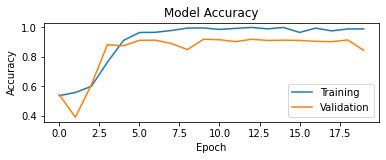

In [ ]:
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

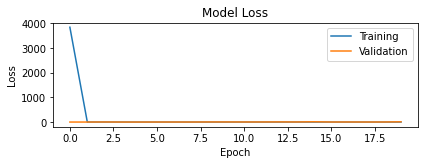

In [ ]:
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()

In [ ]:
headline1 = "Social gatherings of more than six people will be banned across England Wales and Scotland from tomorrow. But what are the new rules what happens if you break them and how do they differ across the nations? ðŸ‘‡"
headline2 = "Korona virus, very new deadly form of virus, china is suffering, may come to India immediately, avoid any form of cold drinks, ice creams, koolfee, etc, any type of preserved foods, milkshake, rough ice, ice colas, milk sweets older then 48 hours, for atleast 90 days from today."
headline3 = "As tuberculosis shaped modernism, so COVID-19 and our collective experience of staying inside for months on end will influence architectureâ€™s near future, @chaykak writes. https://t.co/ag34yZckbU"
headline4 = "SUBHAN ALLAH: AFTER CORONA VIRUS CHINA GOVT LIFTED BAN ON HOLY QURAN & ALLOWED CHINESE MUSLIMS TO READ THEIR SACRED BOOK! SO WHICH OF THE FAVORS OF YOUR LORD WOULD YOU DENY?"
headline6 = "Corona virus from Viet Nam"
headline5 = "#IndiaFightsCorona Following the national trend 17 States/UTs have more new recoveries than new cases. https://t.co/aHWwlaimmb"

In [ ]:
!pip install beautifulsoup4
!pip install google
from googlesearch import search

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
print("Here are some resources that could verify our prediction: ")
query = headline6 #enter headline here
for j in search(query, tld="com", stop=10, pause=1):
  print(j)

Here are some resources that could verify our prediction: 
https://www.vietnam-briefing.com/news/vietnam-business-operations-and-the-coronavirus-updates.html/
http://graphics.reuters.com/world-coronavirus-tracker-and-maps/countries-and-territories/vietnam/
https://www.worldometers.info/coronavirus/country/viet-nam/
https://vietnam.travel/things-to-do/information-travellers-novel-coronavirus-vietnam
https://www.mfa.gov.sg/countries-regions/v/viet-nam/travel-page
https://covid19.who.int/region/wpro/country/vn
https://ourworldindata.org/coronavirus/country/vietnam
https://wwwnc.cdc.gov/travel/notices/covid-unknown/coronavirus-vietnam
https://www.vietnamairlines.com/sg/en/covid-19
https://www.worldbank.org/en/country/vietnam/brief/monitoring-households-and-firms-in-vietnam-during-covid-19
